In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from swmm_api import read_out_file
import os
from matplotlib.gridspec import GridSpec

from matplotlib import rcParams

config = {
            "font.family": 'serif',
            "font.size": 12,# 相当于小四大小
            "mathtext.fontset": 'stix',#matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ['Arial'],#['Times New Roman'],#宋体
            'axes.unicode_minus': False # 处理负号，即-号
         }
rcParams.update(config)

In [6]:
train_rewards = {}
train_rewards['PPO']=np.load('./step3-LFS/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-1']=np.load('./step3-LFS - multitrain/Results_PPO_reward3/Results/1_Train.npy',allow_pickle=True).tolist()['Episode_reward']
#train_rewards['PPO-2']=np.load('./step3-LFS - multitrain/Results_PPO_reward3/Results/2_Train.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-2']=np.load('./step3-LFS - multitrain/Results_PPO_reward3/Results/3_Train.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-3']=np.load('./step3-LFS - multitrain/Results_PPO_reward3/Results/4_Train.npy',allow_pickle=True).tolist()['Episode_reward']

train_rewards['PPO-KGK123-1']=np.load('./step2-finetuneK123 - multitrain/Results_PPO_reward3/Results/1_Train600.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-KGK123-2']=np.load('./step2-finetuneK123 - multitrain/Results_PPO_reward3/Results/2_Train600.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-KGK123-3']=np.load('./step2-finetuneK123 - multitrain/Results_PPO_reward3/Results/2_Train600.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-KGK123']=np.load('./step2-finetuneK123/Results_PPO_reward3/Results/Train600.npy',allow_pickle=True).tolist()['Episode_reward']

train_rewards['PPO-preK123']=np.load('./step1-pretrainK123/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()

#train_rewards['DQN nosafe']=np.load('./step3-DRL fullnosafe/Results_DQN_reward3/Results/Train.npy',allow_pickle=True).tolist()['Episode_reward']
#train_rewards['PPO nosafe']=np.load('./step3-DRL fullnosafe/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()['Episode_reward']

# 画多次训练的范围图

In [7]:
def find_maxmin(id):
    train_rewards['PPO'+id+'-max'] = []
    train_rewards['PPO'+id+'-min'] = []
    n = np.min([len(train_rewards['PPO'+id+'-1']),
               len(train_rewards['PPO'+id+'-2']),
               len(train_rewards['PPO'+id+'-3']),
               len(train_rewards['PPO'+id])])
    for i in range(n):
        train_rewards['PPO'+id+'-max'].append(np.max([train_rewards['PPO'+id+'-1'][i],
                                                    train_rewards['PPO'+id+'-2'][i],
                                                    train_rewards['PPO'+id+'-3'][i],
                                                    train_rewards['PPO'+id][i]]))
        train_rewards['PPO'+id+'-min'].append(np.min([train_rewards['PPO'+id+'-1'][i],
                                                    train_rewards['PPO'+id+'-2'][i],
                                                    train_rewards['PPO'+id+'-3'][i],
                                                    train_rewards['PPO'+id][i]]))

for id in ['-KGK123']:
    print(id)
    find_maxmin(id)

-KGK123


In [8]:
train_rewards['PPO-max'] = []
train_rewards['PPO-min'] = []
n = np.min([len(train_rewards['PPO-1']),
            len(train_rewards['PPO-2']),
            len(train_rewards['PPO-3']),
            len(train_rewards['PPO'])])
for i in range(n):
    train_rewards['PPO-max'].append(np.max([train_rewards['PPO-1'][i],
                                            train_rewards['PPO'][i]]))
    train_rewards['PPO-min'].append(np.min([train_rewards['PPO-1'][i],
                                                train_rewards['PPO-2'][i],
                                                train_rewards['PPO-3'][i],
                                                train_rewards['PPO'][i]]))

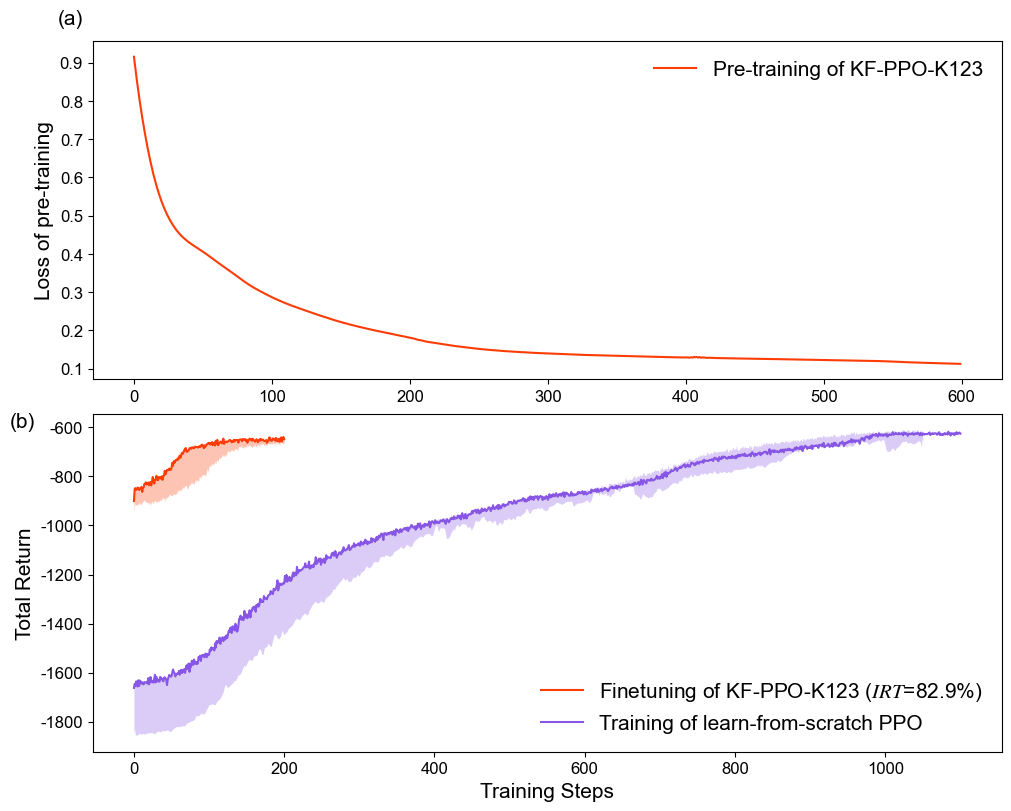

In [13]:
fig = plt.figure(dpi=100,
                 constrained_layout=True,#类似于tight_layout，使得各子图之间的距离自动调整【类似excel中行宽根据内容自适应】
                 figsize=(10,8)
                )
gs = GridSpec(2, 1, figure=fig)#GridSpec将fiure分为3行3列，每行三个axes，gs为一个matplotlib.gridspec.GridSpec对象，可灵活的切片figure

ccf = {'BC':'#7f7f7f',
       'PPO':'#8756e4',
       'K1':'#1f77b4',
       'K2':'#ff7f0e',
       'K3':'#2ca02c',
       'K123':'#fd3c06'
       }

ax4 = fig.add_subplot(gs[0])
ax4.plot(np.array(train_rewards['PPO-preK123']['Loss'][:600])/150,color=ccf['K123'],label='Pre-training of KF-PPO-K123') #3组数据，每组迭代5次training，所以每隔15次选一个数；与其他pretrain保持一致，每3组选一个
#y1, y2 = train_rewards['PPO-preK123-min'], train_rewards['PPO-preK123-max']
#X = [x for x in range(len(train_rewards['PPO-preK123-min']))]
#ax4.fill_between(X, y1, y2, color=ccf['K123'], alpha=0.3)

#ax4.plot(train_rewards['PPO-preK4']['Loss'][:300],label='Pre-training of KF-PPO-K4')
ax4.legend(fontsize=15,frameon=False)
ax4.set_ylabel('Loss of pre-training',fontsize=15)
plt.text(x=-55,y=1, s='(a)',fontsize=15)

##################################################################################################

ax2 = fig.add_subplot(gs[1])

ax2.plot(train_rewards['PPO-KGK123'][:300],color=ccf['K123'],label='Finetuning of KF-PPO-K123 ('+r'${IRT}$'+'=82.9%)')
y1, y2 = train_rewards['PPO-KGK123-min'][:300], train_rewards['PPO-KGK123-max'][:300]
X = [x for x in range(len(train_rewards['PPO-KGK123-min'][:300]))]
ax2.fill_between(X,y1, y2, color=ccf['K123'], alpha=0.3, linewidth=0)

ax2.plot(train_rewards['PPO'][:],color=ccf['PPO'],label='Training of learn-from-scratch PPO')
y1, y2 = train_rewards['PPO-min'][:], train_rewards['PPO-max'][:]
X = [x for x in range(len(train_rewards['PPO-min'][:]))]
ax2.fill_between(X,y1, y2, color=ccf['PPO'], alpha=0.3, linewidth=0)

ax2.legend(fontsize=15,frameon=False)
ax2.set_ylabel('Total Return',fontsize=15)
ax2.set_xlabel('Training Steps',fontsize=15)
#ax2.set_xlabel('Training Epoch',fontsize=20)s
plt.text(x=-165,y=-600, s='(b)',fontsize=15)

plt.savefig('./PPO_train.png',dpi=200,bbox_inches='tight')

# Time
## finetune收敛步数：K123：200
## 选择的pretrained model：K123：600; 每10步记录一次时间，所以下面时间数据的编号除以10

In [10]:
# 每10步记录一次时间
times = {}
#times['DQN'] = np.load('./step3-DRL full/Results_DQN_reward3/time.npy',allow_pickle=True).tolist()
times['PPO'] = np.load('./step3-LFS/Results_PPO_reward3/time.npy',allow_pickle=True).tolist()
times['Pre-PPO-K123'] = np.load('./step1-pretrainK123/Results_PPO_reward3/time.npy',allow_pickle=True).tolist()
times['KG-PPO-K123'] = np.load('./step2-finetuneK123/Results_PPO_reward3/time600.npy',allow_pickle=True).tolist()

In [11]:
LFS,K123 = 110,int(200/10)
print(
    {
        'PPO':times['PPO'][LFS]}
        )
print(
    {
        'KF-PPO-K123':times['KG-PPO-K123'][K123],}
)
print(
    {
        'Pre-PPO-K123':times['Pre-PPO-K123'][60]
    }
)
print(
      times['KG-PPO-K123'][K123]+times['Pre-PPO-K123'][60])

{'PPO': 15209.171149599999}
{'KF-PPO-K123': 2605.3242742}
{'Pre-PPO-K123': 290.9318062}
2896.2560804000004


In [12]:
irf_k123 = (times['PPO'][LFS]-times['KG-PPO-K123'][K123])/times['PPO'][LFS]
print(irf_k123)

0.8287004433986844
